Lambda School Data Science

*Unit 2, Sprint 1, Module 1*

---

# Regression 1

- Begin with baselines for regression
- Use scikit-learn to fit a linear regression
- Explain the coefficients from a linear regression

Brandon Rohrer wrote a good blog post, [“What questions can machine learning answer?”](https://brohrer.github.io/five_questions_data_science_answers.html)

We’ll focus on two of these questions in Unit 2. These are both types of “supervised learning.”

- “How Much / How Many?” (Regression)
- “Is this A or B?” (Classification)

This unit, you’ll build supervised learning models with “tabular data” (data in tables, like spreadsheets). Including, but not limited to:

- Predict New York City real estate prices <-- **Today, we'll start this!**
- Predict which water pumps in Tanzania need repairs
- Choose your own labeled, tabular dataset, train a predictive model, and publish a blog post or web app with visualizations to explain your model!

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- ipywidgets
- pandas
- plotly
- scikit-learn

If your **Plotly** visualizations aren't working:
- You must have JavaScript enabled in your browser
- You probably want to use Chrome or Firefox
- You may need to turn off ad blockers
- [If you're using Jupyter Lab locally, you need to install some "extensions"](https://plot.ly/python/getting-started/#jupyterlab-support-python-35)

In [3]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

# Begin with baselines for regression

## Overview

### Predict how much a NYC condo costs 🏠💸

Regression models output continuous numbers, so we can use regression to answer questions like "How much?" or "How many?" 

Often, the question is "How much will this cost? How many dollars?"

For example, here's a fun YouTube video, which we'll use as our scenario for this lesson:

[Amateurs & Experts Guess How Much a NYC Condo With a Private Terrace Costs](https://www.youtube.com/watch?v=JQCctBOgH9I)

> Real Estate Agent Leonard Steinberg just sold a pre-war condo in New York City's Tribeca neighborhood. We challenged three people - an apartment renter, an apartment owner and a real estate expert - to try to guess how much the apartment sold for. Leonard reveals more and more details to them as they refine their guesses.

The condo from the video is **1,497 square feet**, built in 1852, and is in a desirable neighborhood. According to the real estate agent, _"Tribeca is known to be one of the most expensive ZIP codes in all of the United States of America."_

How can we guess what this condo sold for? Let's look at 3 methods:

1. Heuristics
2. Descriptive Statistics
3. Predictive Model 

## Follow Along

### 1. Heuristics

Heuristics are "rules of thumb" that people use to make decisions and judgments. The video participants discussed their heuristics:




**Participant 1**, Chinwe, is a real estate amateur. She rents her apartment in New York City. Her first guess was `8 million, and her final guess was 15 million.

[She said](https://youtu.be/JQCctBOgH9I?t=465), _"People just go crazy for numbers like 1852. You say **'pre-war'** to anyone in New York City, they will literally sell a kidney. They will just give you their children."_ 

**Participant 3**, Pam, is an expert. She runs a real estate blog. Her first guess was 1.55 million, and her final guess was 2.2 million.

[She explained](https://youtu.be/JQCctBOgH9I?t=280) her first guess: _"I went with a number that I think is kind of the going rate in the location, and that's **a thousand bucks a square foot.**"_

**Participant 2**, Mubeen, is between the others in his expertise level. He owns his apartment in New York City. His first guess was 1.7 million, and his final guess was also 2.2 million.

### 2. Descriptive Statistics

We can use data to try to do better than these heuristics. How much have other Tribeca condos sold for?

Let's answer this question with a relevant dataset, containing most of the single residential unit, elevator apartment condos sold in Tribeca, from January through April 2019.

We can get descriptive statistics for the dataset's `SALE_PRICE` column.

How many condo sales are in this dataset? What was the average sale price? The median? Minimum? Maximum?

In [5]:
import pandas as pd
df = pd.read_csv(DATA_PATH+'condos/tribeca.csv', parse_dates=['SALE_DATE'], index_col='SALE_DATE')

In [6]:
import numpy as np
for i in df.columns.tolist():
    df[i] = df[i].replace(0,np.nan)


cate_cols = df.select_dtypes(include='object').columns
cate_delete = [i for i in cate_cols if len(df[i].unique())==1 or len(df[i].unique())>20] 
df.drop(cate_delete, axis=1, inplace=True)


In [7]:
df.dropna(subset=['ZIP_CODE'], inplace=True)

In [8]:
df['YEAR_BUILT'] = df['YEAR_BUILT'].fillna(df['YEAR_BUILT'].mode()[0])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86 entries, 2019-01-03 to 2019-04-30
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ZIP_CODE           86 non-null     float64
 1   GROSS_SQUARE_FEET  86 non-null     float64
 2   YEAR_BUILT         86 non-null     float64
 3   SALE_PRICE         86 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 3.4 KB


On average, condos in Tribeca have sold for \$3.9 million. So that could be a reasonable first guess.

In fact, here's the interesting thing: **we could use this one number as a "prediction", if we didn't have any data except for sales price...** 

Imagine we didn't have any any other information about condos, then what would you tell somebody? If you had some sales prices like this but you didn't have any of these other columns. If somebody asked you, "How much do you think a condo in Tribeca costs?"

You could say, "Well, I've got 90 sales prices here, and I see that on average they cost \$3.9 million."

So we do this all the time in the real world. We use descriptive statistics for prediction. And that's not wrong or bad, in fact **that's where you should start. This is called the _mean baseline_.**

**Baseline** is an overloaded term, with multiple meanings:

1. [**The score you'd get by guessing**](https://twitter.com/koehrsen_will/status/1088863527778111488)
2. [**Fast, first models that beat guessing**](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa) 
3. **Complete, tuned "simpler" model** (Simpler mathematically, computationally. Or less work for you, the data scientist.)
4. **Minimum performance that "matters"** to go to production and benefit your employer and the people you serve.
5. **Human-level performance** 

Baseline type #1 is what we're doing now.

(Linear models can be great for #2, 3, 4, and [sometimes even #5 too!](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.188.5825))

---

Let's go back to our mean baseline for Tribeca condos. 

If we just guessed that every Tribeca condo sold for \$3.9 million, how far off would we be, on average?

In [10]:
guess = df['SALE_PRICE'].mean()

In [11]:
errors = guess - df['SALE_PRICE']

In [12]:
mean_absolute_error = errors.abs().mean()

In [13]:
print(f'If we just guessed every Tribeca condo sold for ${guess:,.0f},')
print(f'we would be off by ${mean_absolute_error:,.0f} on average.')

If we just guessed every Tribeca condo sold for $3,990,387,
we would be off by $2,865,527 on average.


That sounds like a lot of error! 

But fortunately, we can do better than this first baseline — we can use more data. For example, the condo's size.

Could sale price be **dependent** on square feet? To explore this relationship, let's make a scatterplot, using [Plotly Express](https://plot.ly/python/plotly-express/):

In [14]:
import plotly

In [25]:
df['SALE_PRICE']

SALE_DATE
2019-01-03    2800000
2019-01-07    2650000
2019-01-09    1005000
2019-01-11    1380000
2019-01-14    6924100
               ...   
2019-04-24    5761259
2019-04-29    2600000
2019-04-29     605000
2019-04-30     960000
2019-04-30     975000
Name: SALE_PRICE, Length: 86, dtype: int64

In [32]:
df['ZIP_CODE'] = df['ZIP_CODE'].astype(str)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86 entries, 2019-01-03 to 2019-04-30
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ZIP_CODE           86 non-null     object 
 1   GROSS_SQUARE_FEET  86 non-null     float64
 2   YEAR_BUILT         86 non-null     float64
 3   SALE_PRICE         86 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 3.4+ KB


In [34]:
df.head()

,ZIP_CODE,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE
SALE_DATE,,,,
2019-01-03,10013.0,1840.0,1909.0,2800000
2019-01-07,10004.0,1759.0,2016.0,2650000
2019-01-09,10004.0,1190.0,2005.0,1005000
2019-01-11,10280.0,873.0,2016.0,1380000
2019-01-14,10007.0,2279.0,2016.0,6924100


(array([37.,  9., 14.,  8.,  4.,  4.,  2.,  2.,  5.,  1.]),
 array([  424770.,  1882293.,  3339816.,  4797339.,  6254862.,  7712385.,
         9169908., 10627431., 12084954., 13542477., 15000000.]),
 <BarContainer object of 10 artists>)

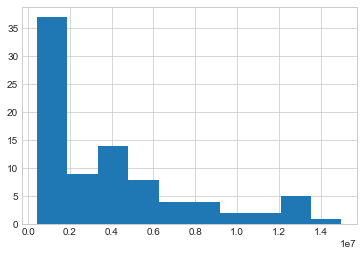

In [29]:
plt.hist(df['SALE_PRICE'])

(array([24., 13.,  9.,  9., 17.,  2.,  8.,  2.,  0.,  2.]),
 array([ 432. ,  887.4, 1342.8, 1798.2, 2253.6, 2709. , 3164.4, 3619.8,
        4075.2, 4530.6, 4986. ]),
 <BarContainer object of 10 artists>)

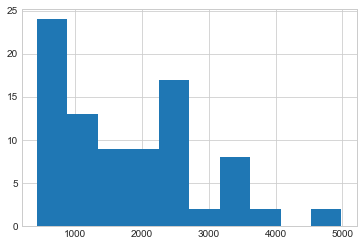

In [35]:
plt.hist(df['GROSS_SQUARE_FEET'])

(array([ 7.,  5.,  5.,  0.,  0.,  0.,  0., 19.,  8., 42.]),
 array([1900. , 1911.6, 1923.2, 1934.8, 1946.4, 1958. , 1969.6, 1981.2,
        1992.8, 2004.4, 2016. ]),
 <BarContainer object of 10 artists>)

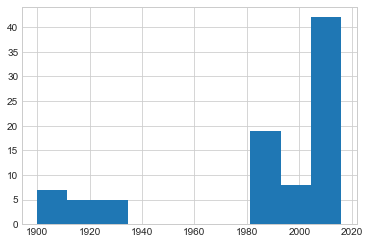

In [36]:
plt.hist(df['YEAR_BUILT'])

In [ ]:
plt.hist(df['YEAR_BUILT'])

### 3. Predictive Model

To go from a _descriptive_ [scatterplot](https://www.plotly.express/plotly_express/#plotly_express.scatter) to a _predictive_ regression, just add a _line of best fit:_

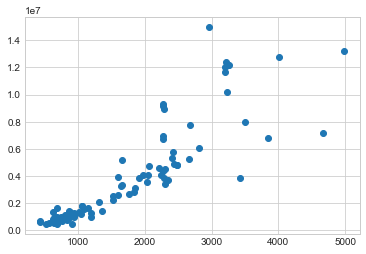

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.scatter(df['GROSS_SQUARE_FEET'], df['SALE_PRICE'])

Roll over the Plotly regression line to see its equation and predictions for sale price, dependent on gross square feet.

Linear Regression helps us **interpolate.** For example, in this dataset, there's a gap between 4016 sq ft and 4663 sq ft. There were no 4300 sq ft condos sold, but what price would you predict, using this line of best fit?

Linear Regression also helps us **extrapolate.** For example, in this dataset, there were no 6000 sq ft condos sold, but what price would you predict?

The line of best fit tries to summarize the relationship between our x variable and y variable in a way that enables us to use the equation for that line to make predictions.





**Synonyms for "y variable"**

- **Dependent Variable**
- Response Variable
- Outcome Variable 
- Predicted Variable
- Measured Variable
- Explained Variable
- **Label**
- **Target**

**Synonyms for "x variable"**

- **Independent Variable**
- Explanatory Variable
- Regressor
- Covariate
- Correlate
- **Feature**


The bolded terminology will be used most often by your instructors this unit.

## Challenge

In your assignment, you will practice how to begin with baselines for regression, using a new dataset!

# Use scikit-learn to fit a linear regression

## Overview

We can use visualization libraries to do simple linear regression ("simple" means there's only one independent variable). 

But during this unit, we'll usually use the scikit-learn library for predictive models, and we'll usually have multiple independent variables.

In [_Python Data Science Handbook,_ Chapter 5.2: Introducing Scikit-Learn](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API), Jake VanderPlas explains **how to structure your data** for scikit-learn:

> The best way to think about data within Scikit-Learn is in terms of tables of data. 
>
> ![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.02-samples-features.png)
>
>The features matrix is often stored in a variable named `X`. The features matrix is assumed to be two-dimensional, with shape `[n_samples, n_features]`, and is most often contained in a NumPy array or a Pandas `DataFrame`.
>
>We also generally work with a label or target array, which by convention we will usually call `y`. The target array is usually one dimensional, with length `n_samples`, and is generally contained in a NumPy array or Pandas `Series`. The target array may have continuous numerical values, or discrete classes/labels. 
>
>The target array is the quantity we want to _predict from the data:_ in statistical terms, it is the dependent variable. 

VanderPlas also lists a **5 step process** for scikit-learn's "Estimator API":

> Every machine learning algorithm in Scikit-Learn is implemented via the Estimator API, which provides a consistent interface for a wide range of machine learning applications.
>
> Most commonly, the steps in using the Scikit-Learn estimator API are as follows:
>
> 1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
> 2. Choose model hyperparameters by instantiating this class with desired values.
> 3. Arrange data into a features matrix and target vector following the discussion above.
> 4. Fit the model to your data by calling the `fit()` method of the model instance.
> 5. Apply the Model to new data: For supervised learning, often we predict labels for unknown data using the `predict()` method.

Let's try it!

## Follow Along

Follow the 5 step process, and refer to [Scikit-Learn LinearRegression documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [ ]:
# 1. Import the appropriate estimator class from Scikit-Learn

from sklearn.linear import LinearRegression


In [ ]:
# 2. Instantiate this class



In [39]:
# 3. Arrange X features matrix & y target vector

X = df[['GROSS_SQUARE_FEET']]
X.shape

y = df['SALE_PRICE']

pandas.core.frame.DataFrame

In [ ]:
# 4. Fit the model



In [ ]:
# 5. Apply the model to new data



So, we used scikit-learn to fit a linear regression, and predicted the sales price for a 1,497 square foot Tribeca condo, like the one from the video.

Now, what did that condo actually sell for? ___The final answer is revealed in [the video at 12:28](https://youtu.be/JQCctBOgH9I?t=748)!___

What was the error for our prediction, versus the video participants?

Let's use [scikit-learn's mean absolute error function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html).

In [ ]:
chinwe_final_guess = [15000000]
mubeen_final_guess = [2200000]
pam_final_guess = [2200000]

This [diagram](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/text_analytics/general_concepts.html#supervised-learning-model-fit-x-y) shows what we just did! Don't worry about understanding it all now. But can you start to match some of these boxes/arrows to the corresponding lines of code from above?

<img src="https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/_images/plot_ML_flow_chart_12.png" width="75%">

Here's [another diagram](https://livebook.manning.com/book/deep-learning-with-python/chapter-1/), which shows how machine learning is a "new programming paradigm":

<img src="https://pbs.twimg.com/media/ECQDlFOWkAEJzlY.jpg" width="70%">

> A machine learning system is "trained" rather than explicitly programmed. It is presented with many "examples" relevant to a task, and it finds statistical structure in these examples which eventually allows the system to come up with rules for automating the task. —[Francois Chollet](https://livebook.manning.com/book/deep-learning-with-python/chapter-1/)

Wait, are we saying that *linear regression* could be considered a *machine learning algorithm*? Maybe it depends? What do you think? We'll discuss throughout this unit.

## Challenge

In your assignment, you will use scikit-learn for linear regression with one feature. For a stretch goal, you can do linear regression with two or more features.

# Explain the coefficients from a linear regression

## Overview

What pattern did the model "learn", about the relationship between square feet & price?

## Follow Along

To help answer this question, we'll look at the  `coef_` and `intercept_` attributes of the `LinearRegression` object. (Again, [here's the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).)


We can repeatedly apply the model to new/unknown data, and explain the coefficient:

In [ ]:
def predict(square_feet):
    y_pred = model.predict([[square_feet]])
    estimate = y_pred[0]
    coefficient = model.coef_[0]
    result = f'${estimate:,.0f} estimated price for {square_feet:,.0f} square foot condo in Tribeca.'
    explanation = f'In this linear regression, each additional square foot adds ${coefficient:,.0f}.'
    return result + '\n' + explanation

print(predict(1497))

In [ ]:
# What does the model predict for low square footage?
print(predict(500))

In [ ]:
# For high square footage?
print(predict(10000))

## Challenge

In your assignment, you will define a function to make new predictions and explain the model coefficient.

# Review

You'll practice these objectives when you do your assignment:

- Begin with baselines for regression
- Use scikit-learn to fit a linear regression
- Make new predictions and explain coefficients

You'll use another New York City real estate dataset. You'll predict how much it costs to rent an apartment, instead of how much it costs to buy a condo.

You've been provided with a separate notebook for your assignment, which has all the instructions and stretch goals. Good luck and have fun!

# Sources

#### NYC Real Estate
- Video: [Amateurs & Experts Guess How Much a NYC Condo With a Private Terrace Costs](https://www.youtube.com/watch?v=JQCctBOgH9I)
- Data: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

#### Baselines
- Will Koehrsen, ["One of the most important steps in a machine learning project is establishing a common sense baseline..."](https://twitter.com/koehrsen_will/status/1088863527778111488)
- Emmanuel Ameisen, [Always start with a stupid model, no exceptions](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)
- Robyn M. Dawes, [The robust beauty of improper linear models in decision making](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.188.5825)

#### Plotly Express
- [Plotly Express](https://plot.ly/python/plotly-express/) examples
- [plotly_express.scatter](https://www.plotly.express/plotly_express/#plotly_express.scatter) docs

#### Scikit-Learn
- Francois Chollet, [Diagram](https://livebook.manning.com/book/deep-learning-with-python/chapter-1/)
- Jake VanderPlas, [_Python Data Science Handbook,_ Chapter 5.2: Introducing Scikit-Learn](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API)
- Olvier Grisel, [Diagram](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/text_analytics/general_concepts.html#supervised-learning-model-fit-x-y)
- [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [sklearn.metrics.mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)